<a target="_blank" href="https://colab.research.google.com/github/spookyboogy/whispy/blob/master/notebooks/colab_nb.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# [Whisper](https://openai.com/research/whisper) + [Speaker Diarization](https://github.com/pyannote/pyannote-audio#neural-speaker-diarization-with-pyannoteaudio)

The purpose of this notebook is to provide an easy way to transcribe an audio file using openAI's Whisper, diarize the audio using pyannote/speaker-diarization, and finally merge the two results to create a diarized transcript.

The benefit of using a colab is that you can use cloud gpu's to achieve faster runtime, but you can also connect to a local runtime to use your own hardware, or clone [the github](https://github.com/spookyboogy/whispy) and run it locally after installing dependencies. The test outputs shown were done using a standard (free) runtime and a 30 second audio file, for reference.

Usage notes:
- The outputs shown are from a previous execution and serve to show what a successful run's ouput would resemble, including timestamps which indicate how long you might to expect this to take for your own audio. If you find it more convenient, you can go to edit -> clear all outputs.

- You can choose to run all cells by going to the menu and selecting Runtime -> Run all (Ctrl+F9). Just make sure to scroll down, expand the section "Uploading your audio file" and upload your file.

- You may also want to change the language(s) being transcribed in by default, which are currently english and spanish. This will be updated soon to use the default option of guessing the correct language unless otherwise specified.

## Automatically save your results upon completion

This prompts you to connect your google drive so that results can be written to your google drive the moment they complete. If your runtime is left idle more than an hour or so after completion, the download prompt which pops up at the end will expire. Connecting your drive at the start frees you from having to worry about this, and allows you to run this notebook in one step (running all cells at once), provided that you remember to upload a file in [the next section](#scrollTo=Hm_PAe882m14).

If you choose not to connect your drive, make sure to return to your session within an hour to catch the download prompt (and/or manually download them in the file explorer) before your session/runtime expires.

In [1]:
#@title Connecting your google drive {display-mode: "form"}

import os
from google.colab import drive, files, output

try:
  drive.mount('/content/drive')
  user_drive = '/content/drive'
  print(f'\nSuccessfully connected to drive.\n')
except:
  user_drive = None
  print(f'\nNot using google drive.\n')


Mounted at /content/drive

Successfully connected to drive.



---
## Uploading your audio file

### Instructions for uploading from google drive (optional):

Find your file audio file in the file explorer on the left and copy its path as shown here, and paste it in the [next cell](#scrollTo=wodY4yjx9rcI&line=2&uniqifier=1).

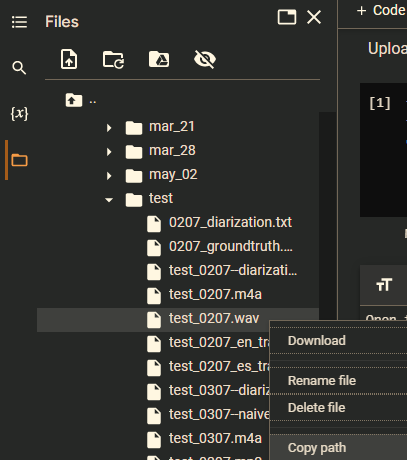 

### Uploading your file

In [2]:
#@title Uploading your file {display-mode: "form"}

if user_drive:
  s = """Copy the path to the audio file in your google drive as shown above,\
       \npaste it in the box and press enter.\
       \n[If uploading a local file, just press enter.]\n"""

  audio_path = input(s)

  if audio_path != '':
    save_directory = os.path.sep.join(audio_path.split(os.path.sep)[:-1])
  else: 
    audio_path = None
    save_directory = '/content'

else:
  # local file upload
  audio_path = None
  save_directory = '/content'

  print("Not connected to google drive...\
       \nUpload a local file or continue using this notebook's test audio.\n")
  
if not audio_path:
  output.clear()
  try:
    print("Upload a local file or cancel the upload to use this notebook's test audio\n")
    uploaded = files.upload()
    audio_path = os.path.join(os.getcwd(), list(uploaded.keys())[0])
  except:
    audio_path = '/content/whispy/tests/test/test_0307.m4a'

print(f'\nUsing base save directory : {save_directory}')
print(f'Using audio : {audio_path}\n')

Upload a local file or cancel the upload to use this notebook's test audio




Using base save directory : /content
Using audio : /content/whispy/tests/test/test_0307.m4a



In [3]:
#@title Android users {display-mode: "form"}

# Write a toggle-able or uncommentable cell for mobile users. It is a known
# issue that android devices cannot send and [enter] input when prompted by
# input() (very cool) 

# if not audio_path:
#   output.clear()
#   try:
#     print("Upload a local file or cancel the upload to use this notebook's test audio\n")
#     uploaded = files.upload()
#     audio_path = os.path.join(os.getcwd(), list(uploaded.keys())[0])
#   except:
#     audio_path = '/content/whispy/test/test_0307.m4a'

# print(f'\nUsing base save directory : {save_directory}')
# print(f'Using audio : {audio_path}\n') 

In [9]:
#@title Installing dependencies and importing libraries {display-mode: "form"}

%%capture
# install and load timer
%pip install ipython-autotime
%load_ext autotime

# install whisper (and dependencies, including librosa, torch, etc)
%pip install -U git+https://github.com/openai/whisper.git 

# install python-ffmpeg
!pip install ffmpeg-python

# install pyannote.audio
!pip install -qq https://github.com/pyannote/pyannote-audio/archive/refs/heads/develop.zip

# clone whispy
!git clone https://github.com/spookyboogy/whispy

import locale
locale.getpreferredencoding = lambda: "UTF-8"

from google.colab import files
import os

import torch, whisper
from whispy import whispy, diarize, merge_diarization

time: 49.2 s (started: 2023-06-02 23:34:42 +00:00)


---
## Transcribing with [Whisper](https://github.com/openai/whisper)

### Load and run the model

In [10]:
#@title Checking available hardware {display-mode: "form"}

hasCuda = torch.cuda.is_available()
print(f'CUDA (gpu inference) available: {hasCuda}')
fp16=hasCuda

CUDA (gpu inference) available: False
time: 1.2 ms (started: 2023-06-02 23:39:13 +00:00)


Select the languages you want to generate transcripts for. The default languages are English and Spanish, but you can remove/change it or add additional languages to transcribe in other by changing the following list variable accordingly. 

Whisper sometimes gracefully handles mixed language speech, but will sometimes translate the spoken language into the given target language. To get best results for mixed language speech, it's often best to transcribe the audio in each featured language for manually copy+replace editing afterwards. in the future, this will be updated with better solutions for properly handling mixed language. 

In [11]:
# langs = ['en']
# langs = ['es']
langs = ['en', 'es']
# langs = ['en', 'es', 'fr']

time: 483 µs (started: 2023-06-02 23:39:15 +00:00)


The default whisper model being used is large-v2, but you can change it here if you wish. Smaller models take less time to run, but are less accurate.

In [12]:
available_model_list = whisper.available_models()
print("\nModels:\n\t" + '\n\t'.join(available_model_list) + '\n')

model_size = "large-v2"


Models:
	tiny.en
	tiny
	base.en
	base
	small.en
	small
	medium.en
	medium
	large-v1
	large-v2
	large

time: 858 µs (started: 2023-06-02 23:39:17 +00:00)


The following cell does all of the transcription work. If you uploaded from google drive, your transcript will be saved to the drive directory where your audio file is located. Otherwise, it will be saved in the colab file explorer in /content. You will be prompted to download a copy of your file after succesful completion.

In [14]:
#@title Running whisper {display-mode: "form"}

transcript_files, transcripts = whispy.main(audio_path, langs=langs)

# Save a copy of your transcript(s)
for lang in transcript_files:
    files.download(transcript_files[lang])


file: /content/whispy/tests/test/test_0307.m4a

Using CUDA (GPU inference) : False

Loading model : large-v2 ... 

100%|██████████████████████████████████████| 2.87G/2.87G [00:27<00:00, 111MiB/s]


Done loading.


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~          
 Starting en transcription...          
 Time : 23:41:03          
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


[00:00.000 --> 00:03.480]  I have this app to our chat.
[00:03.480 --> 00:05.280]  It's called Stop Motion.
[00:05.280 --> 00:05.780]  OK.
[00:05.780 --> 00:07.240]  And it's free?
[00:07.240 --> 00:08.320]  We download it from?
[00:08.320 --> 00:10.120]  Yes, it's free.
[00:10.120 --> 00:15.200]  And so we started with a new movie.
[00:15.200 --> 00:19.360]  I don't know if you want to see what's in it.
[00:19.360 --> 00:23.240]  So I put this piece of tape here just
[00:23.240 --> 00:27.560]  to make sure it's always in the same place.
[00:27.560 --> 00:28.240]  And then.
[00:28.240 --> 00:30.680]  Oh, there's the Apple Store.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~          
 Finished en transcription...          
 Time : 23:43:35          
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~



~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~          
 Starting es transcrip

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 6min 40s (started: 2023-06-02 23:39:32 +00:00)


---
## Diarizing the audio with [pyannote/speaker-diarization](https://huggingface.co/pyannote/speaker-diarization)

Pyannote requires that the input audio file be in .wav format. The following cell will convert your audio to .wav format if your audio file isn't already.

In [ ]:
# #@title Converting audio to .wav if not already .wav {display-mode: "form"}

# if os.path.splitext(audio_path)[1] != '.wav':
#   print(f'\nconverting {audio_path} to .wav\n')
#   new_audio_path = os.path.splitext(audio_path)[0] + '.wav'

#   audio_directory = os.path.sep.join(audio_path.split(os.path.sep)[:-1])
#   print()
#   if new_audio_path not in os.listdir(audio_directory):
#     # try  -loglevel error
#     !ffmpeg -v quiet -i {audio_path} {new_audio_path}
  
#   original_audio_path = audio_path
#   audio_path = new_audio_path
#   print(f'\nSuccessfully converted audio file : \n\t{original_audio_path} -> {audio_path}\n')

#### Not needed anymore, handled inside whispy.diarize

The following cell calls, loads and runs the pyannote/speaker-diarization pipeline on your audio file, and writes the output to a file named your_audio--diarization.txt. You will be prompted to download a copy upon successful completion.

Notes: 

- This can take between 3x-10x times the length of the audio file to complete (depending primarily on how long your file is), even when using a GPU runtime.
- It's unclear that running this using a GPU runtime is all that much more effective than running on CPU. This may be due to the huggingface interface or due to a natural bottleneck in the pyannote/speaker-diarization pipeline. This is apparently a [known issue](https://github.com/pyannote/pyannote-audio/discussions/778).
- There is no verbose option for this pipeline, so don't fret that the results aren't outputting line by line as with whisper.

In [15]:
#@title Running pyannote/speaker-diarization {display-mode: "form"}

diarization_file, diarization = diarize.main(audio_path)

# save a copy of your diarization
files.download(diarization_file)


file: /content/whispy/tests/test/test_0307.m4a


Converting /content/whispy/tests/test/test_0307.m4a to .wav


Successfully converted audio file : 

	/content/whispy/tests/test/test_0307.m4a ---> /content/whispy/tests/test/test_0307.wav


Loading Pipeline...



INFO:pytorch_lightning.utilities.migration.utils:Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file ../root/.cache/torch/pyannote/models--pyannote--segmentation/snapshots/c4c8ceafcbb3a7a280c2d357aee9fbc9b0be7f9b/pytorch_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 2.1.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.0.1+cu118. Bad things might happen unless you revert torch to 1.x.



Done loading.

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~          
 Starting diarization...          
 Time : 23:46:19          
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

[ 00:00:04.075 -->  00:00:04.193] C SPEAKER_01
[ 00:00:05.020 -->  00:00:16.174] D SPEAKER_01
[ 00:00:08.209 -->  00:00:09.323] A SPEAKER_00
[ 00:00:16.174 -->  00:00:29.455] B SPEAKER_00


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~          
 Finished diarization...          
 Time : 23:51:36          
 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~           
 Total runtime: 0:05:17           
~~~~~~~~~~~~~~~~~~~~~~~



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 5min 23s (started: 2023-06-02 23:46:13 +00:00)


## Merging the results and saving a copy of everything:

The following cell merges the transcript file(s) with the diarization file and writes the output to a plain .txt file, a converted .csv version, and a final --joined.csv version where speaker dialogue is condensed to one line per speaker turn. 

It then moves all files generated up to this point into a final folder, zips the folder, and prompts you to download the .zip.

In [16]:
#@title Merging the results and saving everything {display-mode: "form"}

# The first thing this does is print the files being worked with to make sure they're still there
# If the cell fails there, it's likely that your runtime was disconnected since you uploaded your file.
# You can reupload your file as long as the transcripts and diarization are still in 
# your runtime's file explorer. If they are not, but you downloaded them earlier, you can reupload them
# and uncomment the following code before rerunning this cell
# todo: write the optional code which attempts to reinitialize 'transcript_files' and 'diarization_file'

## Merging the diarization with the transcript(s)

print('Transcript files:\n\t' + '\n\t'.join(list(transcript_files.values())))
print(f'\nDiarization file:\n\t{diarization_file}\n')

files_out = []
for transcript in list(transcript_files.values()):
  t_name = transcript.split(os.path.sep)[-1]
  d_name = diarization_file.split(os.path.sep)[-1]
  print(f'{t_name} <--> {d_name}\n')
  diarized_transcripts = merge_diarization.diarize_transcript(transcript, diarization_file, encoding='utf-8')
  files_out += [diarized_transcripts]

## Cleaning up and zipping/downloading files

print(f'\nUsing save directory: {save_directory}\n')

audio_fname = audio_path.split(os.path.sep)[-1]
base_fname = os.path.splitext(audio_fname)[0]
result_folder = f"{save_directory}/whispy_results-{base_fname}"

# Make new directory for saving results in save directory
!mkdir {result_folder}

for lang in range(len(files_out)):
  language = files_out[lang][0].split('_')[-2].upper()
  print(f'\n{language} : \n\t' + '\t\n\t'.join(files_out[lang]))
  print(f"\nMaking directory for {language} results\n")
  # Make a directory for this language
  !mkdir {result_folder}/{language}
  for file_out in files_out[lang]:
    # Copy each file in this language to results folder
    f_name = file_out.split(os.path.sep)[-1]
    !cp {file_out} {result_folder}/{language}/{f_name}

# Copy transcript file(s) to appropriate folder(s)
for transcript_file in transcript_files.values():
  language = transcript_file.split('_')[-2].upper()
  f_name = transcript_file.split(os.path.sep)[-1]
  !cp {transcript_file} {result_folder}/{language}/{f_name}

# Copy diarization file to results folder
diarization_fname = diarization_file.split(os.path.sep)[-1]
!cp {diarization_file} {result_folder}/{diarization_fname}

zip_out_name =  f"{base_fname}-results.zip"
# zip results folder 
!zip -r -q {save_directory}/{zip_out_name} {result_folder}

# save the zip to the user drive if connected and not already saved there
if user_drive and save_directory == '/content':
  user_drive = "/content/drive/My\ Drive"
  !cp {save_directory}/{zip_out_name} {user_drive}/{zip_out_name}

# download copy of zip
files.download(f'{save_directory}/{zip_out_name}')


Transcript files:
	/content/whispy/tests/test/test_0307_en_transcript.txt
	/content/whispy/tests/test/test_0307_es_transcript.txt

Diarization file:
	/content/whispy/tests/test/test_0307--diarization.txt

test_0307_en_transcript.txt <--> test_0307--diarization.txt

test_0307_es_transcript.txt <--> test_0307--diarization.txt


Using save directory: /content


EN : 
	/content/whispy/tests/test/test_0307_en_transcript--merged.txt	
	/content/whispy/tests/test/test_0307_en_transcript--merged.csv	
	/content/whispy/tests/test/test_0307_en_transcript--joined.csv

Making directory for EN results


ES : 
	/content/whispy/tests/test/test_0307_es_transcript--merged.txt	
	/content/whispy/tests/test/test_0307_es_transcript--merged.csv	
	/content/whispy/tests/test/test_0307_es_transcript--joined.csv

Making directory for ES results



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

time: 1.88 s (started: 2023-06-02 23:51:36 +00:00)
